In [8]:
import sys

sys.path.append("../")
sys.path.append("../src")

In [9]:
from src.qlearning import Qlearning
import matplotlib.pyplot as plt

# Set up agent

In [10]:
class Player:
    def __init__(self, get_action) -> None:
        self.get_action = get_action

# Set up training

In [11]:
Q = Qlearning()
Q.training(n_training_game=100000)

100%|██████████| 100000/100000 [13:55<00:00, 119.68it/s]


# Analyze training

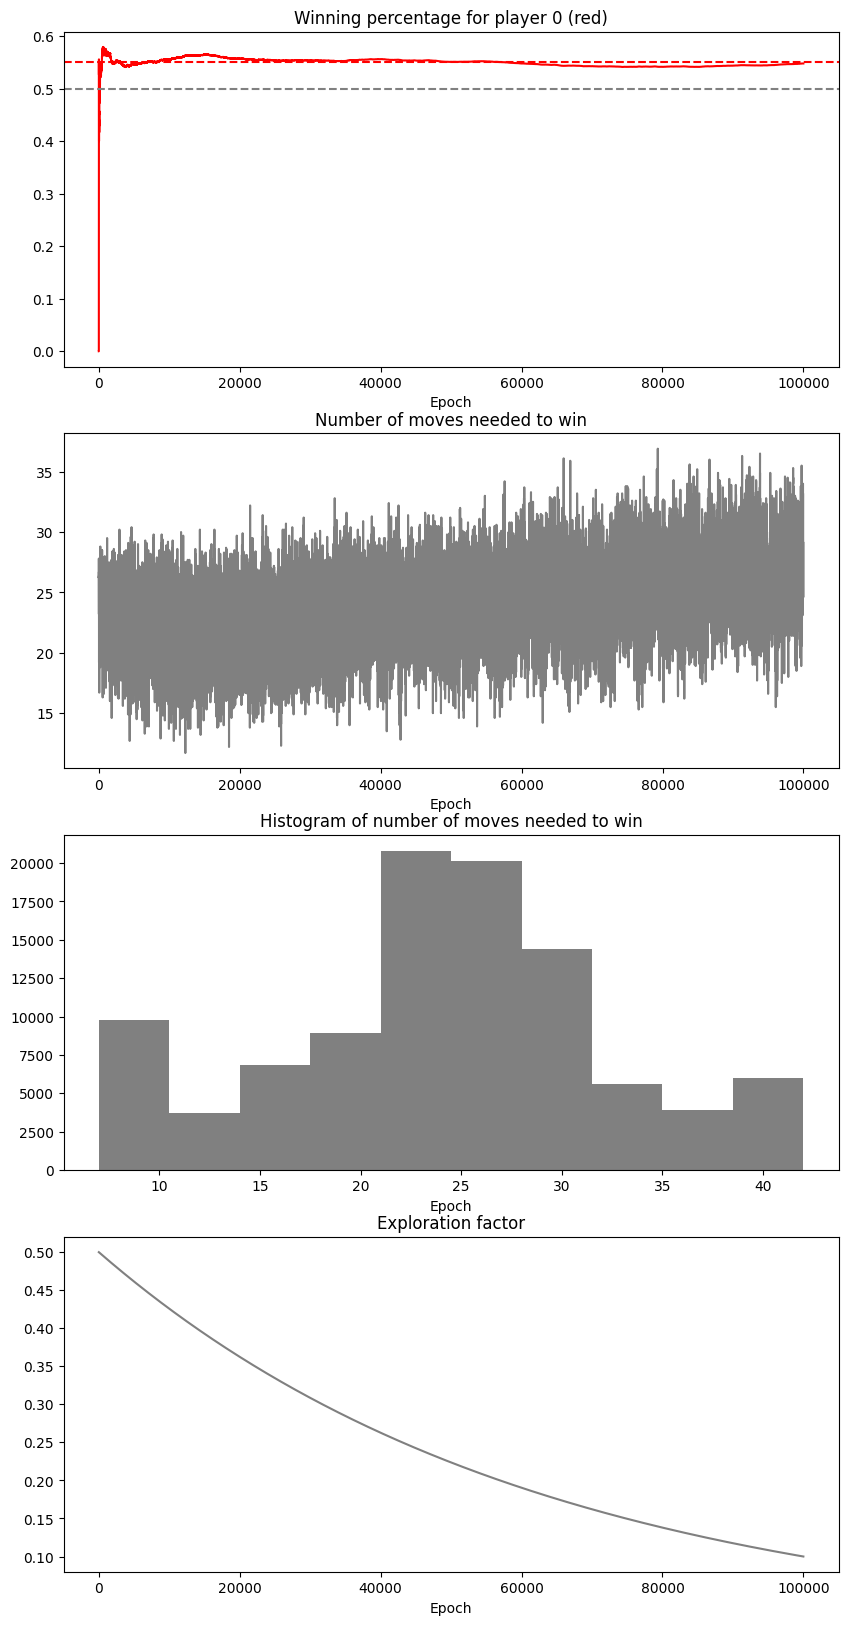

In [12]:
Q.plot_training_stats()
plt.show()

# Look at a game

In [16]:
Q.play()

In [14]:
player = Player(get_action=lambda state: Q.get_action(state))